# Deepformable Tutorial

Welcome to the notebook of deepformable inference tutorial!
We will show you how to run the inference model on a data provided.

## Installation

In [4]:
# This cell installs necessary components if they are missing
import os
from pathlib import Path
import torch # We assume torch already exists

installed_something = False
try:
    import yaml
except ImportError:
    installed_something = True
    !pip install pyyaml==5.1
try:
    import detectron2
except ImportError:
    installed_something = True
    TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
    CUDA_VERSION = torch.__version__.split("+")[-1]
    print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
    # Install detectron2 that matches the above pytorch version
    # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
    !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
    # If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
try:
    import cv2
except ImportError:
    installed_something = True
    !pip install opencv-contrib-python==4.5.5.62
try:
    import sklearn
except ImportError:
    installed_something = True
    !pip install scikit-learn
try:
    import kornia, shapely, pycocotools
except ImportError:
    installed_something = True
    !pip install pycocotools==2.0.4 shapely==1.8.0 kornia==0.6.2

In [6]:
# Try importing deepformable
deepformable_root = Path("/host")
try:
    import deepformable
    deepformable_root = Path(os.path.dirname(deepformable.__file__)).parent
except ImportError:
    installed_something = True
    if deepformable_root.exists():
        !pip install -e {str(deepformable_root)}
    else:
        !git clone "https://github.com/KAIST-VCLAB/DeepFormableTag" deepformable
        deepformable_root = Path(os.path.dirname(os.path.realpath("__file__"))) / "deepformable"
        !pip install -e {str(deepformable_root)}
print("Deepformable root is", str(deepformable_root))

Deepformable root is /content/deepformable/deepformable-release


Once you run the previous cells and install the environment, please restart the runtime to make the installation be effective.

## Loading the model

In [7]:
import time
import tqdm
import json
import cv2
import numpy as np
import torch

from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger

import deepformable.modeling
from deepformable.utils import get_cfg, ModifiedPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog

In [8]:
# Setup Config
cfg = get_cfg()
cfg.OUTPUT_DIR = "/root"
cfg.merge_from_file(deepformable_root / "configs/deepformable-main.yaml")
cfg.MODEL.WEIGHTS = str(deepformable_root / "models/deepformable_model.pth")

device = "cuda"
if not torch.cuda.is_available():
    device = "cpu"
    print("CUDA not found, Will run the inference on CPU")
cfg.MODEL.DEVICE = device

# This option choses which scoring criteria to use for NMS. Options are:
# "bit_similarity" uses the distance of predictions to the provided class of messages [used option in the paper]
# "message_confidence" uses the confidence of how each bit is predicted
# "objectness" uses the predicted objectness 
# "mc_obj_product" uses the product of "message_confidence" and "objectness"
# "mc_obj_bs_product" uses the product of "message_confidence", "bit_similarity" and "objectness"
# cfg.TEST.NMS_SCORE_CRITERIA = "bit_similarity"

# This option disables marker binary message matching
# cfg.TEST.MARKER_POSTPROCESSING = False

# Size of the smallest side of the image during testing. Set to zero to disable resize in testing.
# However, we recommend keeping the original value as it is the resolution that model trained
# cfg.INPUT.MIN_SIZE_TEST = 0

In [9]:
# Handle Metadata
marker_config_path = deepformable_root / "files/template_config.json"
if marker_config_path.exists():
    with open(marker_config_path) as cfg_file:
        marker_config = json.load(cfg_file)
    print("Config loaded!")

    markers = sorted(marker_config['markers'], key=lambda x: x['marker_id'])
    binary_messages = [[float(i) for i in m['binary']] for m in markers]
    thing_classes = [m['text'] for m in markers]

    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)

    metadata_name = cfg.DATASETS.TEST[0]
    metadata = MetadataCatalog.get(metadata_name)
    metadata.set(messages=binary_messages, thing_classes=thing_classes)

Config loaded!


In [10]:
# Here we initialize our model in prediction mode
predictor = ModifiedPredictor(cfg)
model = predictor.model
marker_generator = model.marker_generator

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  renderer.{corner_pts, kernel}
  intermediate_augmentations.0.gamma
  marker_generator.{gamma, messages}


## Marker Generation

Below we generate markers by providing their class id's in a list format to `get_markers_numpy` function.
Returned markers are converted to numpy format automatically. Use this method as it applies gamma correction for printing.

You can also change the `messages` member of marker_generator to generate markers with different messages embedded.

In [11]:
import matplotlib.pyplot as plt
# You can manually specify the messages to generate markers
# Conversion will be done automatically
marker_generator.messages = binary_messages
print(marker_generator.messages.shape)

# Given index of marker will be returned as numpy type
markers_model = marker_generator.get_markers_numpy([i for i in range(len(binary_messages))])

torch.Size([96, 36])


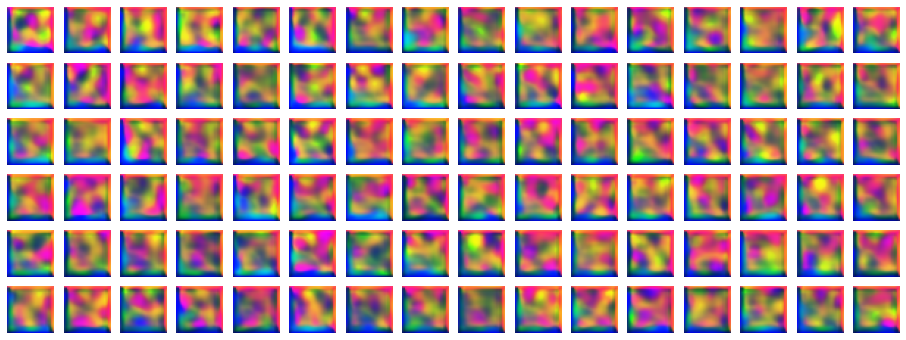

In [12]:
row_size, fig_size = 14, 6
plot_size = len(binary_messages)//row_size, len(binary_messages)//(len(binary_messages)//row_size)
fig, axs = plt.subplots(*plot_size, figsize=(fig_size*(plot_size[1]/plot_size[0]), fig_size))
for idx in range(np.prod(plot_size)):
    i, j = idx % plot_size[0], idx // plot_size[0]
    cur_axs = axs[i, j]
    cur_axs.imshow(markers_model[idx])
    cur_axs.axis('off')

## Inference

Below we predict the markers and visualize the model predictions using our `DeepformableVisualizer`.

In [13]:
from deepformable.utils import DeepformableVisualizer
import cv2

# Load an image with markers
img = cv2.imread(str(deepformable_root/"files/example_input.png"))

# Initialize deepformable visualizer
visualizer = DeepformableVisualizer(metadata)

In [14]:
predictions_d = predictor(img)

predictions_d["image"] = img
predictions = predictions_d["instances"].to("cpu")
vis_out = visualizer.draw_instance_predictions(img, predictions)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


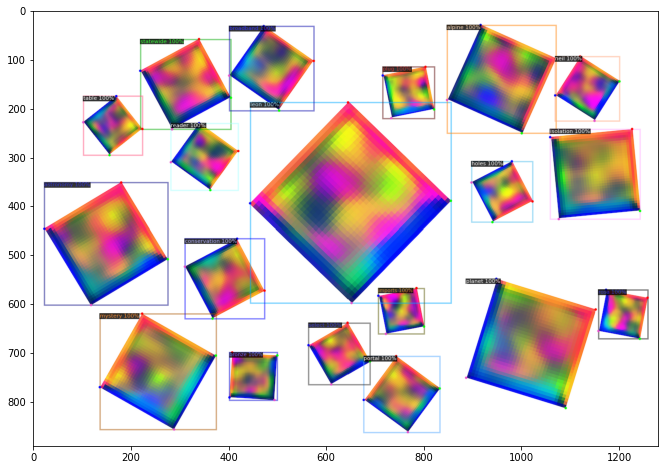

In [15]:
fig = plt.figure(figsize=(12,8))
plt.imshow(vis_out.get_image()[...,::-1])